# TP I : Descentes de Gradient

Ce TP vise à apporter les éléments nécessaires pour comprendre les implementations des descentes de gradients. **C'est un *TP à trous* ; il s'agira de compléter ces trous et d'y ajouter les tests qui vous sembleront utiles.**

Voici un aperçu des points abordés lors de ce TP.

- partie I
    - Définition d'un ensemble de fonctions test
- partie II
    - Calcul du gradient d'une fonction de manière approchée (pour couvrir des cas où le calcul explicite du gradient est impossible ou pénible).
- partie III
    - La descente dans la direction du Gradient à pas constant
    - Optimisation du pas par Backtracking
- partie IV
    - Choix d'une autre direction que le gradient
        - De plus forte pente en norme $l_1$
        - Gradient conjugué
- partie V
    - Accélération : Momentum, Nesterov, Adagrda.
- partie VI
    - La Méthode de Newton et la méthode de quasi-Newton

    
Dans l'ensemble du déroulé du TP vous ferez bien attention à valider par un jeu de tests la validité des programmes écrits. Vous regarderez l'influence des paramètres sur la convergence. Vous comparerez les intérêts des diférentes méthodes les unes par rapport aux autres.

## Attendus de rendu

Jusqu'il n'y a pas très longtemps (l'année dernière, pour être précis), les étudiants étaient évalués sur leur capacité à implémenter des méthodes de descentes opérationnelles et à les comparer entre elles.<br>
Il est aujourd'hui très facile d'implémenter n'importe quel algorithme de descente, en n'importe quel langage (merci ChatGPT). Les attendus sont donc amenés à changer : exit la vérification que le code que vous avez écrit est correct (car il n'est plus possible d'en garantir la source (sachant que ça n'était déjà pas évident par le passé...)).

Cependant, la capacité à produire un benchmark de qualité, et surtout à l'analyser de manière rigoureuse et d'en tirer des conclusions pertinentes, reste quand même propre à l'humain.

**Votre rendu sera donc jugé sur** :
- l'étude effectuée concernant la sensibilité de vos algorithmes de descente aux hyperparamètres / conditions initiales
- l'analyse comparative proposée quant aux différentes implémentations suggérées 
- la précision et concision des résultats présentés (par exemple, dans les choix que vous ferez pour visualiser l'influence de tel ou tel paramètre sur telle ou telle métrique attestant de la convergence de votre algorithme).

Comme vous allez le découvrir, ce TP est très riche et très long. Il n'est pas attendu de vous que vous implémentiez nécéssairement **toutes** les méthodes demandées, ni que vous benchmarkiez pour une méthode donnée, l'influence de **tous** les hyperparamètres. C'est à vous de choisir ce que vous voulez comparer, en fonction de ce qui a le plus éveillé votre curiosité lors des cours en lien avec les méthodes de descente.

À titre d'exemple, voici le genre de *benchmarks* que vous pouvez faire en fonction de leur difficulté (symbolisée par le nombre de ⭐):
- Influence du pas sur le nombre d'itérations dans le cas de la descente de gradient à pas constant et adéquation avec la théorie (⭐)
- Influence d'un hyperparamètre du critère d'Armijo dans le cas d'une descente de gradient pour une fonction convexe (⭐)
- Influence du critère d'arrêt sur le nombre d'itérations de la méthode de descente (⭐)
- Influence conjointe des deux hyperparamètres du critère d'Armijo dans le cas d'une descente de gradient pour une fonction convexe (⭐⭐)
- Influence du choix de la méthode (Fletcher-Reeves vs Polack-Ribière) pour l'algorithme du gradient conjugué pour une classe de fonction non-convexes (⭐⭐)
- Comparaison de rapidité et de précision pour les méthodes de gradient conjugué, Newton (dans le cas quadratique) et quasi-Newton dans le cas général (⭐⭐⭐)

Évidemment, libre à vous de conduire n'importe quel autre type de benchmark, du moment que votre choix est justifié.

⚠️ Un benchmark bien conduit, c'est bien. Mais un benchmark bien conduit **et** bien analysé, c'est mieux ! Pour chaque benchmark que vous produirez, chaque courbe que vous tracerez, vous devez donc vous poser la question "Que puis-je en déduire ? Est-ce conforme à ce que prédit la théorie (ou à minima, l'intuition que j'ai du fonctionnement de la méthode qui est benchmarkée) ?

Ce TP est à rendre par **groupe de 2** ou **par groupe de 3**.<br>
Dans tous les cas, vous devrez rendre un rapport au format pdf regroupant tous les benchmarks et analyses que vous voudrez présenter :
- 10 $\pm$ 1 pages si vous travaillez à 2
- 15 $\pm$ 1 pages si vous travaillez à 3

Des pénalités s'appliqueront sur la notation pour tout rapport trop court ou trop long. **Dans tous les cas, vous indiquerez la répartition du travail au sein du groupe** (qui a réalisé quel benchmark, etc)

# Au travail!

In [2]:
import warnings
import math
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## I- Un set de fonctions tests

Cette partie ne nécessite pas de travail de votre part

Nous allons ici introduire quelques fonctions test qui permettent de représenter les situations suivantes:
- Fonctions globalement convexes ou uniquement localement convexes
- Fonctions admettant ou non un minimum global
- Fonctions admettant ou non des minimums locaux

Nous partons de fonctions définies sur $\mathbb{R}$ mais on verra que cela permet de définir des fonctions "intéressantes" sur $\mathbb{R}^n$.

### Fonctions du set de test

#### 1. Définir des familles de fonctions *convexes* sur $\mathbb{R}$  ou sur une partie de $\mathbb{R}$ ayant un nombre de conditionnement uniquement dépendant des paramètres de la famille.  

In [3]:
def quadratic1_(x,gamma):
    return gamma*(x**2) + x + 1 #valeur de la fonction

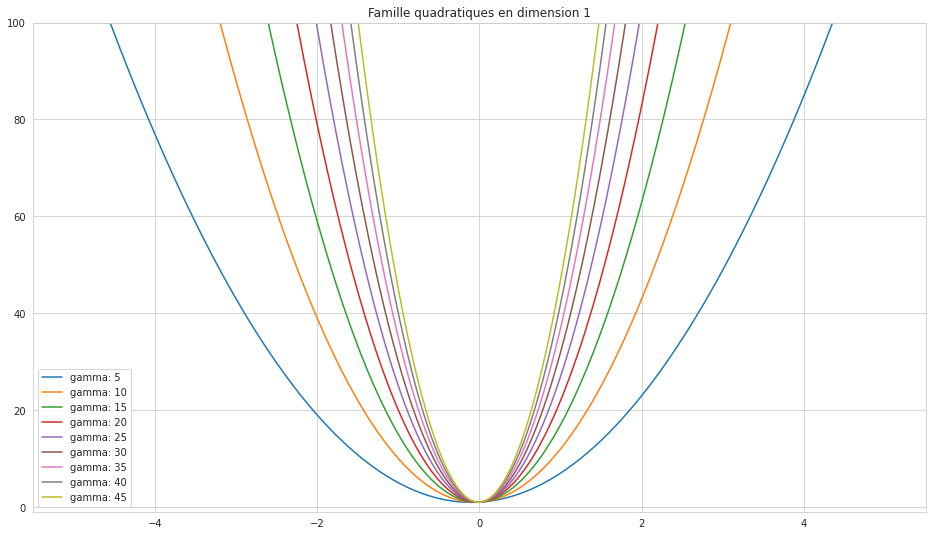

In [4]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-5, 5, 400)
ax.set_ylim(-1, 100)
for gamma in range(5, 50, 5):
    ax.plot(x, quadratic1_(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille quadratiques en dimension 1")
ax.legend()
plt.show()

In [5]:
def cubic1_(x,gamma):
    return x**3 + gamma*x**2 + x + 1 #valeur de la fonction

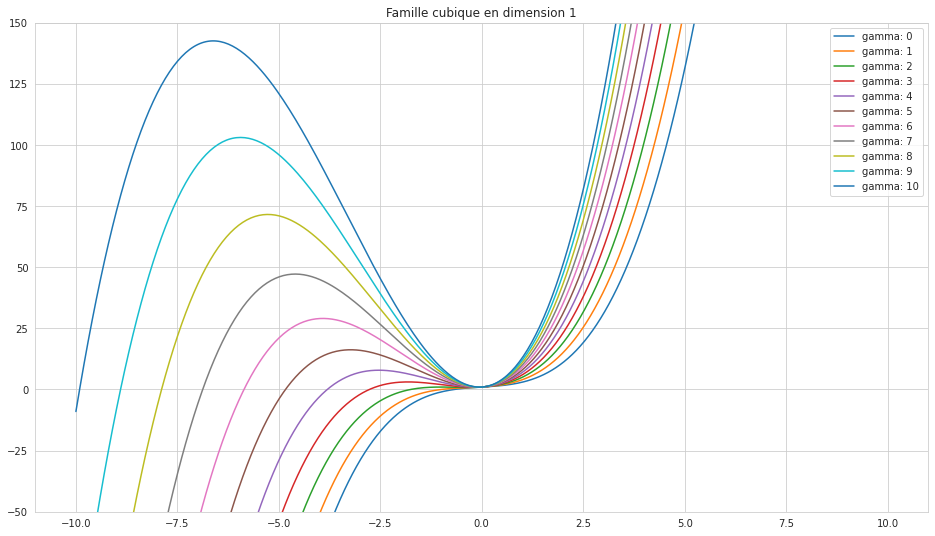

In [6]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-50, 150)
for gamma in range(0, 11, 1):
    ax.plot(x, cubic1_(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille cubique en dimension 1")
ax.legend()
plt.show()

In [7]:
def multitrous1_(x,gamma):
        return 20*np.cos(x**2) + (gamma * x**2) #valeur de la fonction

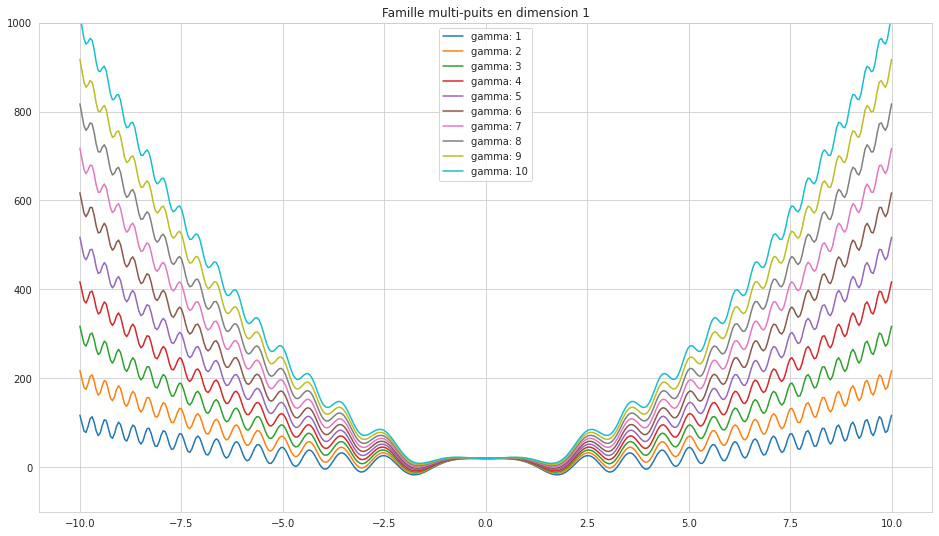

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-100, 1000)
for gamma in range(1, 11, 1):
    ax.plot(x, multitrous1_(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille multi-puits en dimension 1")
ax.legend()
plt.show()

#### 2. Faire de même avec des fonctions sur $\mathbb{R}^2$.

In [9]:
def quadratic2_(x,gamma):
        return quadratic1_(x[0],gamma[0])+quadratic1_(x[1],gamma[1]) #valeur de la fonction

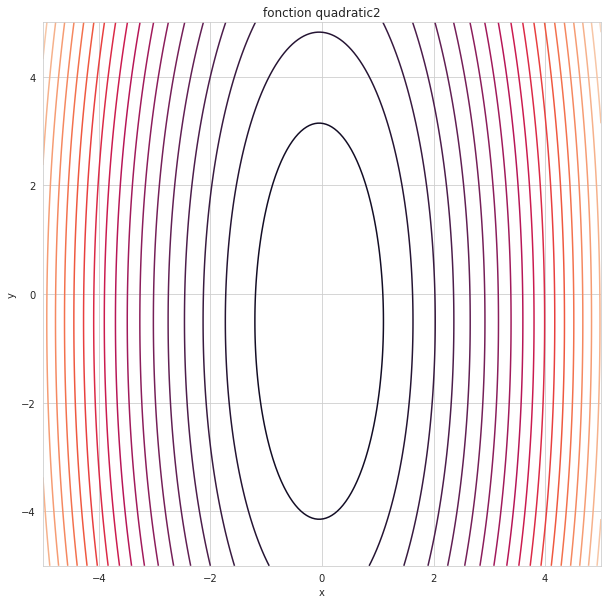

In [10]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -5, 5, -5, 5
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

gamma=np.zeros(2)
gamma[0]=10
gamma[1]=1

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=quadratic2_(np.array([X[i,j],Y[i,j]]),gamma)

fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

ax.contour(X, Y, Z,20) 
  
ax.set_title('fonction quadratic2') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 

plt.show()

In [11]:
def cubic2_(x,gamma=10):
        return cubic1_(x[0],gamma)+cubic1_(x[1],gamma) #valeur de la fonction

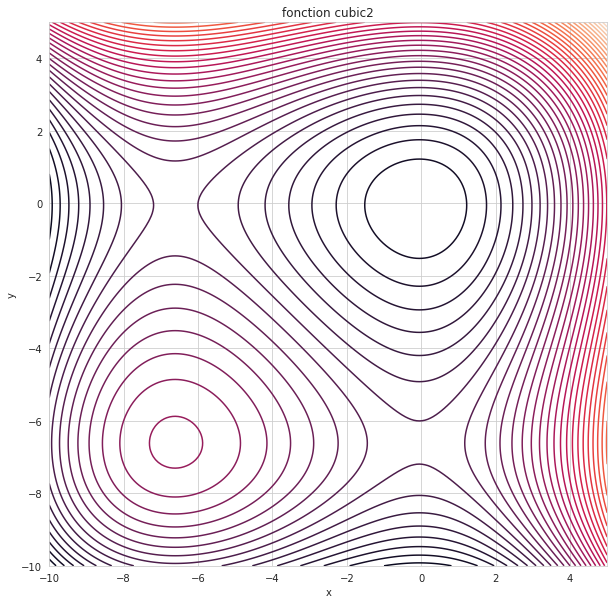

In [12]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -10, 5, -10, 5
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)


Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=cubic2_(np.array([X[i,j],Y[i,j]]))


fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

ax.contour(X, Y, Z,50) 
  
ax.set_title('fonction cubic2') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 

plt.show()

In [13]:
def multitrous2_(x,gamma=4):
        return multitrous1_(x[0],1)+multitrous1_(x[1],gamma) #valeur de la fonction

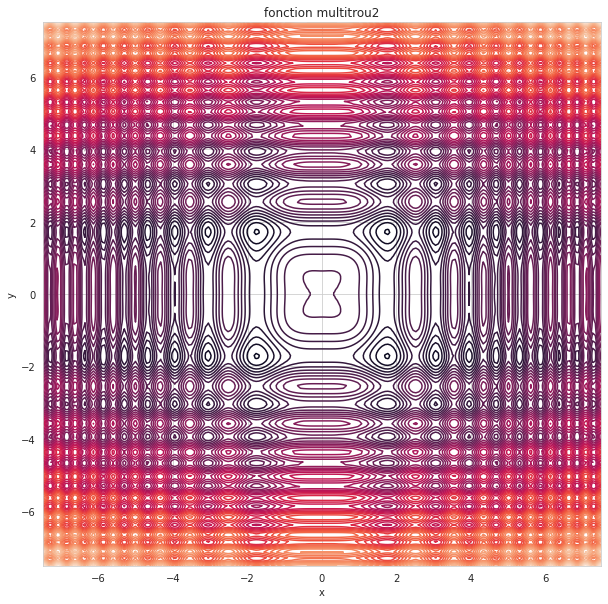

In [14]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -7.5, 7.5, -7.5, 7.5
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)


Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=multitrous2_(np.array([X[i,j],Y[i,j]]))


fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

ax.contour(X, Y, Z,50) 
  
ax.set_title('fonction multitrou2') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 

plt.show()

#### 3. On construit ici une fonction convexe en dimension n

On va prendre comme fonction test la fonction convexe "générique" dans $\mathbb{R}^n$, $ x \mapsto \frac{1}{2}x^T A x-b^Tx$, 

où A est une matrice symétrique définie positive de taille $(n,n)$ et $b$ un vecteur de $\mathbb{R}^n$.

On a vu en cours que cette fonction est convexe, qu'elle admet donc un minimum global sur $\mathbb{R}^n$, et que ce minimum est atteint au point où son gradient s'annule, c'est à dire au point où $Ax=b$.


Une manière commode de construire une matrice $A$ symétrique définie positive est de la voir comme une matrice de la forme $A=U^T U$ avec $U$ triangulaire supérieure car cela nous permet  à la fois de s'assurer qu'elle est symétrique, inversible, positive et en plus de "contrôler" les valeurs propres de $A$ et donc son conditionnement.
Le conditionnement de $A$ est le rapport entre la plus grande et la plus petite de ses valeurs propres. C'est le carré du rapport entre la plus grande et la plus petite des valeurs propres de $U$ qu'on trouve sur la diagonale.


In [15]:
def create_system (dim,cond=10,seed=100):
    np.random.seed(seed)
    A=0.1*np.random.uniform(-math.sqrt(cond),math.sqrt(cond),size=(dim,dim))
    A=np.triu(A)
    # on remplace la diagonale de A par des valeurs aléatoires positives entre 1 et sqrt(cond)
    A=A-np.diag(np.diag(A))+np.diag(np.random.uniform(1.,math.sqrt(cond),size=(dim))) 
    # on impose les deux premiers termes de la diagonale diagonale de A pour fixer le conditionnement
    A[0,0]=1.
    A[1,1]=math.sqrt(cond)
    b=1.*np.random.randint(-10,10,size=(dim))
    A=A.T @ A
    return A,b

In [16]:
A,b = create_system(5,cond=10)
print (A,b)

[[ 1.         -0.14017151 -0.04773927  0.21805557 -0.3132433 ]
 [-0.14017151 10.01964805  0.6583972  -0.757152    0.19409444]
 [-0.04773927  0.6583972   2.43429773 -0.44063605 -0.24929874]
 [ 0.21805557 -0.757152   -0.44063605  7.56250011 -0.42402717]
 [-0.3132433   0.19409444 -0.24929874 -0.42402717  1.21928084]] [ 4.  7.  6.  5. -3.]


In [17]:
def quadraticn_(x):
    return (x.T@A@x)/2-b.T@x #valeur de la fonction

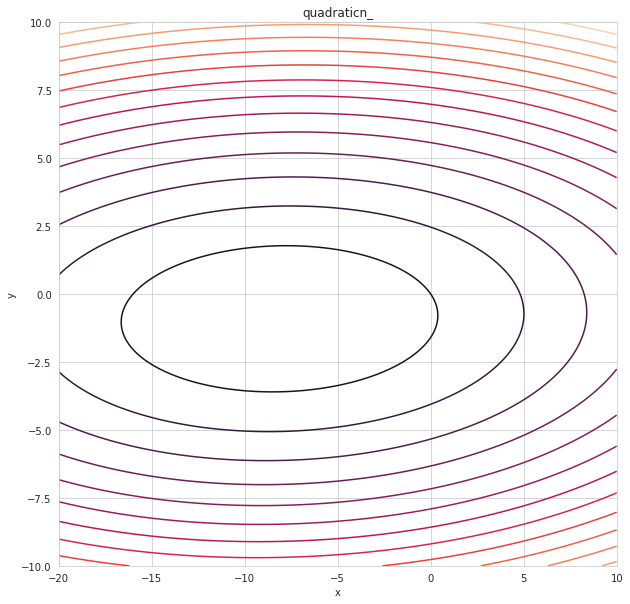

In [18]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -20, 10, -10, 10

x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

dim=2
A,b = create_system(dim,cond=10)

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=quadraticn_(np.array([X[i,j],Y[i,j]]))

fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

ax.contour(X, Y, Z,15) 
  
ax.set_title('quadraticn_') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 

plt.show()

#### 4. La banane de Rosenbrock

Voici une fonction célèbre pour tester les algorithmes d'optimisation.

$$f(x,y)=(x-1)^2+\gamma (x^2-y)^2.$$

Ce n'est pas évident à visualiser mais cette fonction présente un minimum global unique qui se situe au fond d'une vallée très étroite et en forme de parabole.


In [83]:
def Rosenbrock(x,gamma=100):
        return (x[0]-1)**2+gamma*(x[0]**2-x[1])**2 #valeur de la fonction

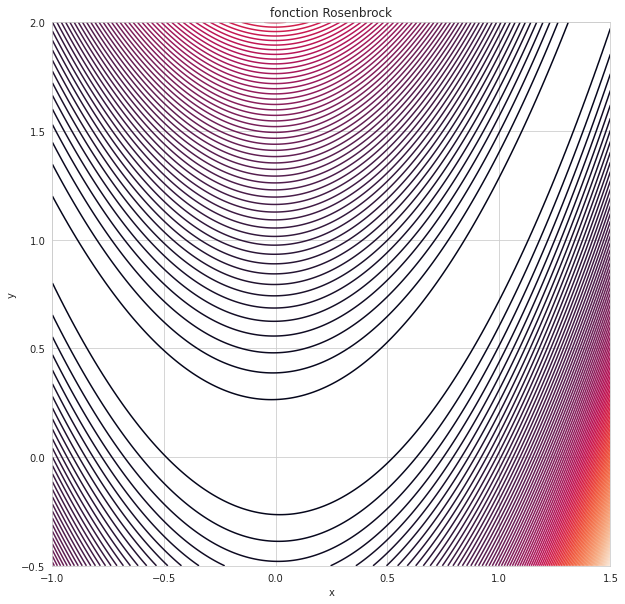

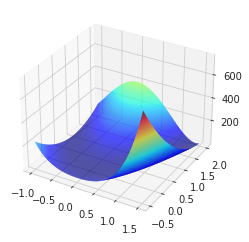

In [84]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -1, 1.5, -0.5, 2
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=Rosenbrock(np.array([X[i,j],Y[i,j]]))

fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 
ax.contour(X, Y, Z,100) 
ax.set_title('fonction Rosenbrock') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
cmap='jet', edgecolor='none')
plt.show()

### Conclusion

On voit sur ces quelques exemples que des fonctions d'apparence "inoffensives" peuvent avoir des comportements complexes en ce qui concerne leurs extrema locaux ou globaux.

${\bf Nous \, vous \, invitons \, à \, tester}$ les programmes que vous écrirez:
* sur la fonction quadratique pour la dimension n=2 puis n=10, et pour des conditionnements variant de 5 à 1000.
* sur la fonction de Rosenbrock pour des valeurs de gamma variant de 5 à 100

## II- Différencier une fonction numériquement

On verra aussi comment calculer le gradient de manière approchée. Cela est particulièrement utile quand la seule information disponible sur la fonction à minimiser est sa valeur en tout point.

Pour calculer le gradient d'une fonction on a déjà besoin de savoir calculer la dérivée d'une fonction réelle, et on en tire ensuite une version numérique du gradient.

### Le calcul numérique de la dérivée

Pour $h$ assez petit on peut approcher $f'(x)$ par 
$$ f'(x) \simeq \frac{f(x + h) - f(x)}{h} .$$
L'erreur de l'approximation est en $o(1)$ quand $h \to 0$. 

$$ $$
On peut en réalité faire un peu mieux en approchant $f'(x)$ par 
$$f'(x) \simeq \frac{f(x+h)-f(x-h)}{2h}.$$
On trouve que l'erreur d'approximation dans le second cas est désormais en $o(h)$ quand $h \to 0$; ce qui est a priori meilleur.

#### 1. Utiliser la démarche précédente pour approcher la dérivée partielle d'une fonction en un point. Cette fonction sera notée `partial`.

In [21]:
def partial(f, x, i=0, dx=1e-8):
    """Computes i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: coordinate along which derivative is computed.
        dx: slack for finite difference.
        
    Output:
        (float)

    """
    h = np.zeros(x.size)
    h[i] = dx
    return (f(x + h) - f(x - h)) / (2*dx)

#### 2. Comparer `partial` à l'expression exacte de la dérivée partielle d'une fonction de votre choix. 

In [22]:
partial(lambda x: np.exp(x), np.array([100]))

array([2.68811544e+43])

In [23]:
np.exp(np.array([100]))

array([2.68811714e+43])

### Le calcul du gradient

Comme dit précédemment, comme le calcul exact du gradient n'est parfois pas possible ou facile, on se garde la possibilité de calculer numériquement le gradient d'une fonction.

#### 1. Écrire une fonction `gradient` qui renvoie le gradient d'une fonction en un point grâce à la fonction précédente

In [25]:
def gradient(f, x, dx=1e-8):
    """Computes gradient of f at point x.
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of size domain of f.
        
    """
    return np.array([partial(f, x, i, dx) for i in range(x.size)])


#### 2. Tester cette fonction gradient sur une fonction connue.

In [26]:
x=np.zeros(2)
x[0]=1
x[1]=10
gradient(lambda x: x[0]**5 + x[1]**2, x)

array([ 4.9999997 , 20.00000165])

## III- Descente du gradient

Tout d'abord, nous allons implémenter des descentes qui se feront dans la direction du Gradient


### le cas générique de descente de gradient avec un pas constant


* prendre un point de départ au hasard ${\bf x_0}$.

Quand on est au point ${\bf x_k}$

* calculer le gradient de $f$ en ce point $\nabla f({\bf x_k})$

* On choisit une direction de descente ${\bf d}_k = - \nabla f({\bf x}_k)$

* avancer dans cette direction : ${\bf x}_{k+1} = {\bf x}_k + \eta \, {\bf d}_k$

et on recommence cette dernière étape jusqu'à ce qu'on arrive à un point fixe c.a.d. que 
$|| {\bf x}_{k+1} - {\bf x}_k|| < \varepsilon$ avec $\varepsilon$ une toute petite valeur.

Implémenter cette méthode, la tester sur des fonctions tests définies plus haute, observer en particulier le comportement en fonction de $\mu$ qui est le pas constant.

Attention: bien prévoir dans le code des conditions pour éviter de se retrouver piégé dans des boucles infinies !!!

#### 1. Implémenter cette méthode, la tester sur des fonctions tests définies plus haute, observer en particulier le comportement en fonction de $\eta$ qui est le pas constant.

Attention: bien prévoir dans le code des conditions pour éviter de se retrouver piégé dans des boucles infinies !!!
On conseille de stocker les différentes valeurs calculées pour les points ${\bf x_k}$ afin de pouvoir "regarder" la manière dont la convergence se passe.

In [31]:
def desc_grad_const (f,x0,eta=0.001,eps=1E-6, max_iter = 10000):
    """
    Description: 
    Parameters:
    x0: point initial
    f: fonction à minimiser
    eta: valeur constante du pas (0.001 par défaut)
    eps: critère à partir duquel on considèrera que la suite est "constante"
    
    Output
    Tableau contenant l'ensemble des positions successives p_k
    """
    xk = [x0]
    while len(xk) <= max_iter:
        gradient_xk = gradient(f, xk[-1])
        new_xk = xk[-1] - eta * gradient_xk
        xk.append(new_xk)
        if np.linalg.norm(new_xk - xk[-2]) < eps:
            break
    return xk


#### 2. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [96]:
dim=10
cond=100.
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_grad_const(quadraticn_,x0,eta=0.01)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)
print("=========================================")
print(res)

Nb itérations 975
x_calculé [0.99989089 1.00000016 1.00000036 1.00000458 0.99999788 0.9999988
 1.00000074 1.00000063 0.9999989  1.00000392]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.00235294,  0.91423278,  0.16362689,  0.09157832,  0.44539776,
        0.70635193,  0.43276649,  0.67614605,  0.91847571,  0.03765246]), array([0.00947626, 0.84376918, 0.36671667, 0.23166144, 0.73679648,
       0.88772345, 0.65562526, 0.89971274, 0.98366587, 0.09482823]), array([0.02264446, 0.86514003, 0.51901642, 0.34959889, 0.87348026,
       0.96249435, 0.79229526, 0.93530014, 1.02395686, 0.14299919]), array([0.03663398, 0.87754721, 0.62843464, 0.45142913, 0.94075311,
       0.98792902, 0.87094801, 0.95890814, 1.02941542, 0.19092775]), array([0.05040574, 0.89230883, 0.70565267, 0.53908713, 0.97478663,
       0.99779395, 0.9164107 , 0.97085485, 1.02951167, 0.23882757]), array([0.06372472, 0.90530667, 0.76028569, 0.6145696 , 0.9929827 ,
       1.0012

Nous allons maintenant montrer l'influence du pas sur le nombre d'itérations dans le cas de la descente de gradient à pas constant et adéquation avec la théorie

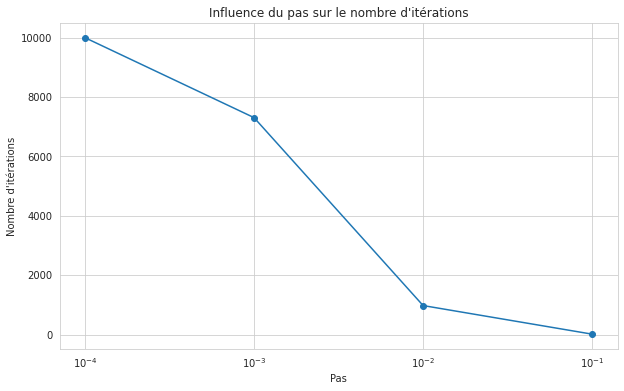

In [98]:
import matplotlib.pyplot as plt

# Fonction quadratique
dim = 10
cond = 100.
A, b = create_system(dim, cond)
x_exact = np.zeros(dim) + 1.
b = A @ x_exact

# Point de départ
x0 = np.zeros(dim)

# Liste des valeurs de pas à tester
etas = [0.0001, 0.001, 0.01, 0.1]

# Nombre d'itérations pour chaque pas
num_iters = []

for eta in etas:
    res_const = desc_grad_const(lambda x: 0.5 * x.T @ A @ x - b.T @ x, x0, eta=eta)
    num_iters.append(len(res_const))

# Graphique du nombre d'itérations en fonction du pas
plt.figure(figsize=(10, 6))
plt.plot(etas, num_iters, 'o-')
plt.xscale('log')
plt.xlabel('Pas')
plt.ylabel('Nombre d\'itérations')
plt.title('Influence du pas sur le nombre d\'itérations')
plt.grid(True)
plt.show()


L'impact du pas de la descente de gradient à pas constant peut être illustré en utilisant différentes valeurs de pas, au dessus (0.0001, 0.001, 0.01 et 0.1). En surveillant le nombre d'itérations nécessaire pour atteindre la convergence on percois qu'un pas plus important mene a une convergence plus rapide. En général, un pas trop petit peut entraîner une convergence très lente (nécessitant de nombreuses itérations), tandis qu'un pas trop grand peut entraîner des oscillations autour du minimum ou même une divergence de l'algorithme

/tmp/ipykernel_36206/3197018730.py:13: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([partial(f, x, i, dx) for i in range(x.size)])
/tmp/ipykernel_36206/3243085672.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(x_hist, f(np.array(x_hist)), 'o-', label="descente de gradient")


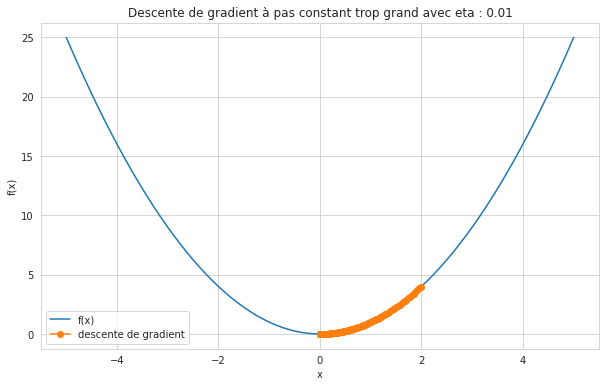

x_calculé [[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[4.852279516386025e-05]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]


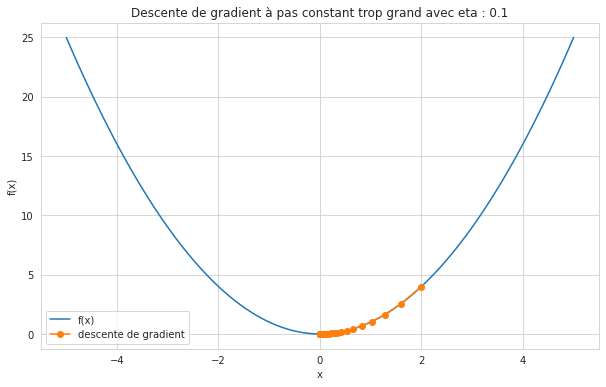

x_calculé [[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[3.831238870732885e-06]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]


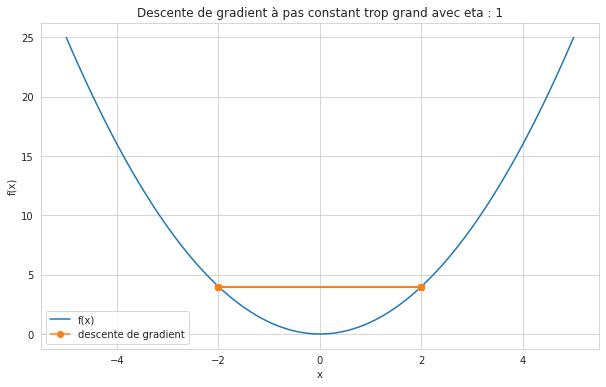

x_calculé [[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[1.9999753086399323]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]


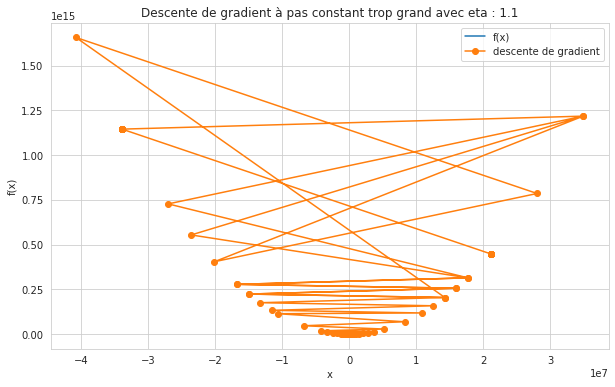

x_calculé [[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[21153675.89480392]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]


In [122]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction quadratique
f = lambda x: x**2

def draw_gradient_descent_with_big_step(our_eta):
    x0= np.array([2])
    x_hist = desc_grad_const(f, x0, eta=our_eta, eps= 1E-6, max_iter=1000);
    # Descente de gradient à pas constant
    #print(x_hist)
    # # Points pour la fonction
    x_points = np.linspace(-5, 5, 100)
    y_points = f(x_points)

    # Graphique
    plt.figure(figsize=(10, 6))
    plt.plot(x_points, y_points, label="f(x)")
    plt.plot(x_hist, f(np.array(x_hist)), 'o-', label="descente de gradient")
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(f"Descente de gradient à pas constant trop grand avec eta : {our_eta}")   
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("x_calculé",x_hist[-1])



different_eta = [0.01, 0.1, 1, 1.1]

for el in different_eta:
    draw_gradient_descent_with_big_step(el)


On remarque que si le pas est trop important alors on peut avoir une descente de gradient divergent, comme dans le cas où eta = 1, et des resultat finaux peux precis. 

Dans le cas ou eta = 1, il reste au starting point, en effet ... theory.

     

### 1ère amélioration: le choix d'un pas "optimal" à chaque étape par *backtracking* (ou rebroussement avec critère d'Armijo)

Vous devriez avoir constaté que le choix du pas de descente dans le cas constant est crucial pour garantir la convergence de l'algorithme de descente. Dans cette section on s'intéresse à un calcul adaptatif du pas de descente qui permet de mieux garantir la convergence de notre algo. Le désavantage est le temps que prend désormais chaque itération pour s'exécuter.


Ici on veut imposer la décroissance de la suite $f({\bf x}_k)$ ce qui nous assurera la convergence. Mais pour assurer la convergence vers un minimum, il faut imposer un peu plus que simplement de descendre, c'est ce que traduit le critère d'Armijo.

On prend ici deux paramètres $0<\alpha<0.5$ et $0<\beta<1$.

On cherche un $\eta$ qui vérifie:
$$ f({\bf x}_k+\eta {\bf d}_k) < f({\bf x}_k) + \alpha \, \eta \, {\bf d}_k ^T \, \nabla f({\bf x}_k)\quad (1).$$

Un tel $\eta$ existe dès que ${\bf d}_k$ est une direction de descente (c'est à dire dès que ${\bf d}_k ^T \, \nabla f({\bf x}_k) \, <\, 0$.

* On part de $\eta = 1$

* si la condition $(1)$ ci-dessus est vérifiée on choisit cette valeur de $\eta$

* sinon on change $\eta$ en $\beta \, \eta$

Et on recommence jusqu'à ce que la condition $(1)$ soit vérifiée.




#### 1. Écrire une fonction `backtracking` qui permet de calculer le pas par *backtracking* avec critère d'Armijo à une itération donnée. Pour rappel le *backtracking* a deux hyper-paramètres $\alpha$ et $\beta$ que vous mettrez par défaut à $0.4$ et $0.8$.

In [35]:
# Cette fonction génère la taille du pas optimal vérifiant le critère d'Amijo
    
def backtrack(x0, f, dir_x, alpha=0.4, beta=0.8, max_iter=1000):
        """
    Description: 
    Parameters:
    x0: point actuel
    f: fonction à minimiser
    dir_x: direction dans laquelle on souhaite aller
    max_iter maximum amount of iterations
    
    Output
    valeur du pas optimal
    """
        eta = 1.0
        f_x0 = f(x0)
        grad_f_x0 = gradient(f, x0)

        i = 0
        while f(x0 + eta * dir_x) > f_x0 + alpha * eta * np.dot(grad_f_x0, dir_x) and i < max_iter:
            eta = beta * eta
            i += 1

        return eta

La méthode est donc très analogue à la précédente

* prendre un point de départ au hasard ${\bf x_0}$.

Quand on est au point ${\bf x_k}$

* Calculer le gradient de $f$ en ce point $\nabla f({\bf x_k})$

* Choisir une direction de descente ${\bf d}_k = - \nabla f({\bf x}_k)$

* Trouver $\eta_k$ par "backtracking" dans la direction ${\bf d}_k$

* Avancer dans cette direction et avec ce pas : ${\bf x}_{k+1} = {\bf x}_k + \eta \, {\bf d}_k$

et on recommence ces étapes jusqu'à ce qu'on arrive à un point fixe c.a.d. que 
$|| {\bf x}_{k+1} - {\bf x}_k|| < \varepsilon$ avec $\varepsilon$ une toute petite valeur.

#### 2. Implémenter cette méthode

In [36]:
def desc_grad_opti(f, x0, eps=1E-6, max_iter=10000):
    xk = [x0]
    while len(xk) <= max_iter:
        grad_xk = gradient(f, xk[-1])
        dir_xk = -grad_xk
        eta_k = backtrack(xk[-1], f, dir_xk)
        new_xk = xk[-1] + eta_k * dir_xk
        xk.append(new_xk)
        if np.linalg.norm(new_xk - xk[-2]) < eps:
            break
    return xk


#### 3. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [37]:
dim = 10
cond = 100.
A, b = create_system(dim, cond)
x_exact = np.zeros(dim) + 1.
b = A @ x_exact

x0 = np.zeros(dim)
res = desc_grad_opti(lambda x: 0.5 * x.T @ A @ x - b.T @ x, x0)

print("Nb itérations", len(res))
print("x_calculé", res[-1])
print("x_exact", x_exact)

Nb itérations 599
x_calculé [0.99994935 0.99999996 1.00000019 1.0000022  0.99999905 0.99999943
 1.00000032 1.00000042 0.99999936 1.00000189]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [85]:
x0 = np.array([-1.9, 2])
res = desc_grad_opti(Rosenbrock, x0)

print("Nb itérations", len(res))
print("x_calculé", res[-1])
print("x_exact", np.array([1, 1]))


Nb itérations 6765
x_calculé [0.99956808 0.99913524]
x_exact [1 1]


#### 4. Comparer la descente par backtracking et la descente à pas constant (à vous de réfléchir à ce que vous voulez comparer).

In [39]:
import time

# Fonction quadratique
dim = 10
cond = 100.
A, b = create_system(dim, cond)
x_exact = np.zeros(dim) + 1.
b = A @ x_exact

# Point de départ
x0 = np.zeros(dim)

# Descente de gradient à pas constant
start = time.time()
res_const = desc_grad_const(lambda x: 0.5 * x.T @ A @ x - b.T @ x, x0)
end = time.time()
print(f"Descente de gradient à pas constant : {len(res_const)} itérations, {res_const[-1]} valeur finale, {end - start} secondes.")

# Descente de gradient par backtracking
start = time.time()
res_backtrack = desc_grad_opti(lambda x: 0.5 * x.T @ A @ x - b.T @ x, x0)
end = time.time()
print(f"Descente de gradient par backtracking : {len(res_backtrack)} itérations, {res_backtrack[-1]} valeur finale, {end - start} secondes.")


Descente de gradient à pas constant : 7307 itérations, [0.99891995 1.00000172 1.00000401 1.00004559 0.99997895 0.99998844
 1.00000727 1.00000632 0.99998938 1.00003915] valeur finale, 0.8091144561767578 secondes.
Descente de gradient par backtracking : 599 itérations, [0.99994935 0.99999996 1.00000019 1.0000022  0.99999905 0.99999943
 1.00000032 1.00000042 0.99999936 1.00000189] valeur finale, 0.238816499710083 secondes.


## IV- Changement de direction de descente

Maintenant nous ne nous déplacerons plus nécessairement dans la direction de $-\nabla f({\bf x_k})$ mais dans une autre direction $d_k$ qui vérifiera bien évidemment $\langle \nabla f({\bf x_k}) , d_k \rangle < 0$ afin que ce soit bien une direction de descente (et non de montée !!!).

### 1. Choisir une direction de descente selon la plus forte pente en norme $l_1$

Nous allons ici choisir la descente de plus forte pente dans le cas de la norme $\ell_1$ : la direction de descente $d_k$ suit le vecteur de la base canonique de plus grande dérivée partielle en valeur absolue. 

$$ {\bf d}_k = -\langle \nabla f({\bf x}_k),e_i \rangle \, e_i$$
où $i$ est le plus petit indice tel que:
$ \left| \dfrac{\partial f}{\partial x_i}({\bf x}_k) \right| = \|\nabla f({\bf x}_k)\|_{\infty}  $

#### a. Écrire une fonction `dsgd` qui calcule cette direction de descente de plus forte pente dans le cas de la norme $\ell_1$. 

In [ ]:
def dsgd(f, x):
    
    """
    Description: 
    Parameters:
    x: point actuel
    f: fonction à minimiser
    
    Output
    vecteur de direction de descente de gradient maximal en norme l1
    """
    
    # 👷 À VOUS DE JOUER 👷
    # return ???

#### b. Ecrire la descente à pas optimal avec cette direction de descente

${\bf x}_{k+1} = {\bf x}_k + \eta_k {\bf d}_k$, où $\mu_k$ est calculé de manière optimale par l'algorithme de rebroussement avec critère d'Amijo défini plus haut.

In [ ]:
def desc_l1_opti (f, x0, eps=1E-6):
    # 👷 À VOUS DE JOUER 👷
    # return xk

#### c. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [ ]:
# 👷 À VOUS DE JOUER 👷 (quadratic_n)

In [ ]:
# 👷 À VOUS DE JOUER 👷 (Rosenbrok)

#### d. Comparer la descente $\ell_1$ et la descente du gradient

In [ ]:
# 👷 À VOUS DE JOUER 👷

### 2. le gradient conjugué (Fletcher-Reeves)

Dans la méthode du gradient conjugué, on modifie la direction de descente en ajoutant à l'opposé du gradient un terme dépendant des directions de descente précédentes. Ce choix de descente est fait pour rendre deux directions de descentes orthogonales pour le produit scalaire qui vient de la Hessienne.

Ce calcul (qui est direct quand la fonctionnelle est quadratique) peut devenir compliqué quand la Hessienne n'est pas directement accessible.

Une des méthodes les plus populaires pour une fonctionnelle quelconque est celle proposée par Fletcher-Reeves. Nous vous invitons à faire un peu de bibliographie pour trouver comment la direction est choisie.

#### a. Ecrire la descente à pas optimal avec cette direction de descente

In [ ]:
def desc_FR_opti (f, x0, eps=1E-6):
    # 👷 À VOUS DE JOUER 👷
    # return xk

#### b. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [ ]:
# 👷 À VOUS DE JOUER 👷 (quadratic_n)

In [ ]:
# 👷 À VOUS DE JOUER 👷 (Rosenbrok)

### 2. le gradient conjugué (Polack-Ribière)

Une méthode alternative est celle proposée par Polack-Ribière. À noter qu'elle est (théoriquement) équivalente à la méthode de Fletcher-Reeves lorsque la fonctionnelle à minimiser est quadratique, mais sensiblement plus efficace dans le cas général (non quadratique)

#### a. Ecrire la descente à pas optimal avec cette direction de descente

In [ ]:
def desc_PR_opti (f, x0, eps=1E-6):
    # 👷 À VOUS DE JOUER 👷
    # return xk

#### b. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [ ]:
# 👷 À VOUS DE JOUER 👷 (quadratic_n)

In [ ]:
# 👷 À VOUS DE JOUER 👷 (Rosenbrok)

### 3. visualiser une comparaison des différents algorithmes de descente et leur sensibilité par rapport au conditionnement

Nous vous proposons de visualiser le comportement de ces différents algorithmes de descente.

Tout d'abord en dimension 2, vous pouvez tracer la succession des points $x_k$ pour les algorithmes implémentés.

In [ ]:
dim=2
A,b = create_system(dim,cond=3.)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)

plt.figure(figsize=(10,10))

Liste_method=(desc_grad_const,desc_grad_opti,desc_l1_opti,desc_FR_opti,desc_PR_opti)

for method in Liste_method:

    if method == desc_grad_const:
        res = method(quadraticn_,x0,eta=0.9/cond)
    else:
        res = method(quadraticn_,x0)

    plt.plot(res[:,0], res[:,1],label=method)

plt.legend()

nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -0.1, 1.1, -0.1, 1.3

x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=quadraticn_(np.array([X[i,j],Y[i,j]]))
        
        
plt.contour(X, Y, Z,25) 

plt.show()

En dimension n plus grande (par exemple n=10), vous pourrez tracer le nombre d'itérations nécessaires pour converger en fonction du conditionnement (5,10,50,100,500,1000).

In [ ]:
# 👷 À VOUS DE JOUER 👷

Vous pouvez aussi regarder pour une certaine valeur de conditionnement, comment varie la distance à la solution exacte en fonction de l'itération.

In [ ]:
# 👷 À VOUS DE JOUER 👷

### 4. comportement si la fonction à optimiser n'est pas convexe sur $\mathbb{R}^2$ et n'admet pas un minimum global

Nous vous proposons de regarder le comportement de ces différents algorithmes de descente dans le cas de quelques fonctions introduites au début du TP, telles que multitrous2, cubic2.

In [ ]:
# 👷 À VOUS DE JOUER 👷 (multitrous2)

In [ ]:
# 👷 À VOUS DE JOUER 👷 (cubic2)

Que constatez-vous ?

In [ ]:
# 👷 À VOUS DE JOUER 👷

## V Accélérations

Il y a des stratégies standards d'accélération de descente de gradients ; on en invente même tous les ans. Il n'y a pas nécessairement de relation d'ordre entre celles-ci, certaines sont plus adaptées que d'autres à des problèmes spécifiques et inversement. On vous propose d'implémenter 3 méthodes "simples" : *momentum*, *Nesterov* et *Adagrad* (*Adaptive gradient*). Contrairement aux deux premières pour lesquelles le pas reste fixe en fonction des variables à optimiser, *Adagrad* adapte le pas d'une variable à l'autre.

1. Implémenter la *Momentum Optimisation*.

In [ ]:
# 👷 À VOUS DE JOUER 👷

2. Implémenter la *Nesterov Optimisation*.

In [ ]:
# 👷 À VOUS DE JOUER 👷

3. Implémenter la *Adagrad Optimisation*.

In [ ]:
# 👷 À VOUS DE JOUER 👷

4. Comparer l'accélération choisie avec les méthodes précédentes précédentes.

In [ ]:
# 👷 À VOUS DE JOUER 👷

## VI - "Les" méthodes de Newton

### 1. la méthode de Newton

Dans les méthodes de descente précédentes, on cherchait à chaque étape à minimiser le Développement Limité d'ordre 1 de J au voisinage de ${\bf x_k}$: $h \mapsto f({\bf x_k}) + \nabla f({\bf x_k}) ^T h$.

Dans la méthode de Newton, on cherche à minimiser le Développement Limité d'ordre 2 de J au voisinage de ${\bf x}_k$ : $h \mapsto f({\bf x}_k) + \nabla f({\bf x}_k) ^T h + \dfrac{1}{2}h^T H_f({\bf x}_k) h$ où $H_f({\bf x}_k)$ est la Hessienne de $f$ au point ${\bf x}_k$.

A quelle direction de descente, cette minimisation nous amène-t-elle?

Réponse:


On passe de la direction ${\bf d}_k$ à la direction ${\bf d}_{k+1}$ par la relation de récurrence:
$${\bf d}_{k+1}=-H_f({\bf x}_k)^{-1} \, \nabla f({\bf x}_k) .$$

#### a. Implémenter la méthode de Newton.

En apparence, implémenter la méthode de Newton (qui converge très rapidement) ne semble pas différent que les méthodes de descente vues précédemment

En réalité cette méthode n'est pas facile à implémenter et surtout coûteuse car il faut calculer à chaque itération la Hessienne de $f$ au point ${\bf x}_k)$ et ensuite l'inverser.

Vous pouvez essayer de l'implémenter dans le cas particulier de la fonction quadraticn_ car alors la matrice Hessienne est constante et ne dépend donc pas du point ${\bf x}_k)$, ce qui vous permet de calculer une fois pour toute son inverse (par le module linalg de numpy par exemple).

Par contre implémenter cette méthode dans le cas d'une fonction dont on ne connaît pas explicitement la Hessienne, et surtout l'inverse de cette dernière est à déconseiller.

In [ ]:
# 👷 À VOUS DE JOUER 👷

#### b. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [ ]:
# 👷 À VOUS DE JOUER 👷

### 2. la méthode de quasi-Newton

Pour éviter les inconvénients de la méthode de Newton, en particulier lorsque la Hessienne n'est plus constante, une idée est d'introduire une suite de matrices $H_k$ qui sont une approximation de $\bf {l'inverse}$ de la Hessienne au point ${\bf x}_k$.

Cette méthode qui s'appelle méthode BFGS (des initiales des auteurs qui l'ont introduite), a l'avantage (énorme) de ne pas nécessiter le calcul de la Hessienne ou de son inverse. on retrouve donc en terme d'implémentation la simplicité des méthodes de descente, tout en ayant les propriétés de convergence de la méthode de Newton.

L'algorithme le décrivant est le suivant (très analogue aux algorithmes de descente):

* prendre un point de départ quelconque ${\bf x}_0$
* prendre une matrice $H_0$ quelconque, par exemple $H_0= I_n$ 

Quand on est au point ${\bf x}_k$

* Choisir une direction de descente ${\bf d}_k = -H_k \, \nabla f({\bf x}_k)$

* Trouver $\eta_k$ par "backtracking" dans la direction ${\bf d}_k$

* Avancer dans cette direction et avec ce pas : ${\bf x}_{k+1} = {\bf x}_k + \eta_k \, {\bf d}_k$

* Calculer $H_{k+1}$ en fonction de $H_{k+1}$, $f({\bf x}_k)$, $f({\bf x}_{k+1})$, $\nabla f({\bf x}_k)$ et $\nabla f({\bf x}_{k+1})$.

et on recommence ces étapes jusqu'à ce qu'on arrive à un point fixe c.a.d. que 
$|| {\bf x}_{k+1} - {\bf x}_k|| < \varepsilon$ avec $\varepsilon$ une toute petite valeur.


La formule qui donne la suite des matrices $H_{k}$ semble à première vue horrible. Mais elle se programme en Python en 1 ligne en ne faisant que des multiplications de matrices et de vecteurs.

#### a. Implémenter la méthode de Quasi-Newton BFGS.

In [ ]:
def desc_BFGS_opti (f, x0, eps=1E-6):
    # 👷 À VOUS DE JOUER 👷
    # return xk

#### b. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [ ]:
# 👷 À VOUS DE JOUER 👷 (quadratic_n)

In [ ]:
# 👷 À VOUS DE JOUER 👷 (Rosenbrok)

In [ ]:
# 👷 À VOUS DE JOUER 👷 (cubic2)

3. Comparer la méthode de quasi-Newton aux descentes précédentes.

In [ ]:
# 👷 À VOUS DE JOUER 👷